In [1]:
# %pip install --quiet optuna

In [2]:
import optuna
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [3]:
EPOCHS = 200
PATIENCE = 10 #patience when applying early stopping callback
NTRIALS = 500
TIMEOUT = 600

In [4]:
# Cargar el archivo NPY
intervals = np.load('C:/Users/TSE LATAM/Documents/Navarra/TFM/datasets/medidas_2d/1601/intervals_1601.npy')
intervals_ref = np.load('C:/Users/TSE LATAM/Documents/Navarra/TFM/datasets/medidas_2d/1601/intervals_ref_1601.npy')
labels_1601 = np.load('C:/Users/TSE LATAM/Documents/Navarra/TFM/datasets/medidas_2d/1601/labels_1601.npy')
labels_1601_ref = np.load('C:/Users/TSE LATAM/Documents/Navarra/TFM/datasets/medidas_2d/1601/labels_ref_1601.npy')
test_intervals_1601 = np.load('C:/Users/TSE LATAM/Documents/Navarra/TFM/datasets/medidas_2d/1601/test_intervals_1601.npy')
test_labels_1601 = np.load('C:/Users/TSE LATAM/Documents/Navarra/TFM/datasets/medidas_2d/1601/test_labels_1601.npy')
x_out_1601 = np.load('C:/Users/TSE LATAM/Documents/Navarra/TFM/datasets/medidas_2d/1601/X_out_1601.npy')
x_out_1601_ref = np.load('C:/Users/TSE LATAM/Documents/Navarra/TFM/datasets/medidas_2d/1601/X_out_ref_1601.npy')
x_out_1601_test = np.load('C:/Users/TSE LATAM/Documents/Navarra/TFM/datasets/medidas_2d/1601/X_out_test_1601.npy')

In [5]:
# Crear un DataFrame
df = pd.DataFrame({
    'intervals': intervals,   # Asumimos que 'intervals' está previamente cargado
    'labels_1601': labels_1601  # Asumimos que 'labels_1601' está previamente cargado
})

# Combinar 'intervals' y 'labels_1601' en una columna y factorizar para asignar un identificador único
df['category'] = pd.factorize(list(zip(df['intervals'], df['labels_1601'])))[0]

# Usar groupby para agrupar por categoría y recoger los índices en listas
positions_by_category = df.groupby('category').apply(lambda x: x.index.tolist()).tolist()

# Ordenar cada lista de posiciones de forma descendente
positions_by_category_sorted = [sorted(positions, reverse=True) for positions in positions_by_category]

# Convertir la lista de listas en un array de numpy con dtype=object para manejar listas de diferentes longitudes
x_train_a_position = np.array(positions_by_category, dtype=object)
x_train_b_position = np.array(positions_by_category_sorted, dtype=object)

# Opcionalmente, aplana las listas si es necesario para alguna otra operación
indices_x_train_a_position = [item for sublist in x_train_a_position for item in sublist]
indices_x_train_b_position = [item for sublist in x_train_b_position for item in sublist]

C:\Users\TSE LATAM\AppData\Local\Temp\ipykernel_9200\1085437932.py:8: FutureWarning: factorize with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  df['category'] = pd.factorize(list(zip(df['intervals'], df['labels_1601'])))[0]
C:\Users\TSE LATAM\AppData\Local\Temp\ipykernel_9200\1085437932.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  positions_by_category = df.groupby('category').apply(lambda x: x.index.tolist()).tolist()


In [6]:

# Crear un DataFrame
df_2 = pd.DataFrame({
    'test_intervals_1601': test_intervals_1601,
    'test_labels_1601': test_labels_1601
})

# Combinar 'test_intervals_1601' y 'test_labels_1601' en una columna y factorizar para asignar un identificador único
df_2['category'] = pd.factorize(list(zip(df_2['test_intervals_1601'], df_2['test_labels_1601'])))[0]

# Usar groupby para agrupar por categoría y recoger los índices en listas
positions_by_category_y = df_2.groupby('category').apply(lambda x: x.index.tolist()).tolist()

# Ordenar cada lista de posiciones de forma descendente
positions_by_category_sorted_y = [sorted(positions, reverse=True) for positions in positions_by_category_y]

# Convertir la lista de listas en un array de numpy con dtype=object para manejar listas de diferentes longitudes
y_test_a_position = np.array(positions_by_category_y, dtype=object)
y_test_b_position = np.array(positions_by_category_sorted_y, dtype=object)

# Opcionalmente, aplana las listas si es necesario para alguna otra operación
indices_y_test_a_position = [item for sublist in y_test_a_position for item in sublist]
indices_y_test_b_position = [item for sublist in y_test_b_position for item in sublist]


C:\Users\TSE LATAM\AppData\Local\Temp\ipykernel_9200\3852324818.py:8: FutureWarning: factorize with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  df_2['category'] = pd.factorize(list(zip(df_2['test_intervals_1601'], df_2['test_labels_1601'])))[0]
C:\Users\TSE LATAM\AppData\Local\Temp\ipykernel_9200\3852324818.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  positions_by_category_y = df_2.groupby('category').apply(lambda x: x.index.tolist()).tolist()


In [7]:
# Reordenar los datasets según los índices proporcionados
x_train = x_out_1601[indices_x_train_a_position]
x_train_b = x_out_1601[indices_x_train_b_position]
x_test = x_out_1601_test[indices_y_test_a_position]
x_test_b = x_out_1601_test[indices_y_test_b_position]

# Recortar un píxel de la parte superior de cada imagen en todos los datasets
x_train = x_train[:, 1:1601, :, :]
x_train_b = x_train_b[:, 1:1601, :, :]
x_test = x_test[:, 1:1601, :, :]
x_test_b = x_test_b[:, 1:1601, :, :]

In [8]:
# Normalizar los datos de entrenamiento y prueba
x_train = x_train.astype('float32') / 255.0
x_train_b = x_train_b.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_test_b = x_test_b.astype('float32') / 255.0

In [9]:
import optuna
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tqdm import tqdm

def build_autoencoder(trial):
    # Espacio de búsqueda de hiperparámetros
    num_filters_1 = trial.suggest_categorical('num_filters_1', [16, 32])
    num_filters_2 = trial.suggest_categorical('num_filters_2', [32, 64])
    num_filters_3 = trial.suggest_categorical('num_filters_3', [64, 128])
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-3)
    alpha_leaky_relu = trial.suggest_float('alpha_leaky_relu', 0.01, 0.3)
    l2_reg = trial.suggest_float('l2_reg', 1e-5, 1e-3)

    # Definir el modelo
    input_img = Input(shape=(1600, 128, 1))

    # Encoder
    x = Conv2D(num_filters_1, (3, 3), padding='same', kernel_regularizer=l2(l2_reg))(input_img)
    x = LeakyReLU(alpha=alpha_leaky_relu)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(dropout_rate)(x)
    
    x = Conv2D(num_filters_2, (3, 3), padding='same', kernel_regularizer=l2(l2_reg))(x)
    x = LeakyReLU(alpha=alpha_leaky_relu)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(dropout_rate)(x)
    
    x = Conv2D(num_filters_3, (3, 3), padding='same', kernel_regularizer=l2(l2_reg))(x)
    x = LeakyReLU(alpha=alpha_leaky_relu)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(dropout_rate)(x)

    # Decoder
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(num_filters_3, (3, 3), padding='same', kernel_regularizer=l2(l2_reg))(x)
    x = LeakyReLU(alpha=alpha_leaky_relu)(x)
    x = BatchNormalization()(x)
    
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(num_filters_2, (3, 3), padding='same', kernel_regularizer=l2(l2_reg))(x)
    x = LeakyReLU(alpha=alpha_leaky_relu)(x)
    x = BatchNormalization()(x)
    
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(num_filters_1, (3, 3), padding='same', kernel_regularizer=l2(l2_reg))(x)
    x = LeakyReLU(alpha=alpha_leaky_relu)(x)
    x = BatchNormalization()(x)
    
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    optimizer = Adam(learning_rate=learning_rate)
    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer=optimizer, loss='mse')

    return autoencoder

def objective(trial):
    model = build_autoencoder(trial)

    # Entrenar el modelo con barra de progreso
    epochs = 5  
    with tqdm(total=epochs, desc="Training", unit="epoch") as pbar:
        for epoch in range(epochs):
            history = model.fit(x_train, x_train_b,
                                epochs=5,  # Entrenamos una época a la vez
                                batch_size=32,
                                validation_data=(x_test, x_test_b),
                                verbose=0)  # verbose=0 para evitar demasiada salida en Optuna
            pbar.update(1)  # Actualiza la barra de progreso

    # Evaluar el modelo en el set de validación
    val_loss = model.evaluate(x_test, x_test_b, verbose=0)
    
    return val_loss


In [10]:
# Crear el estudio de Optuna
study = optuna.create_study(direction='minimize')  # Minimizamos la pérdida
study.optimize(objective, n_trials=10)  # Realiza 50 pruebas

# Imprimir los mejores hiperparámetros encontrados
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


[I 2024-08-20 13:50:31,501] A new study created in memory with name: no-name-54529907-62c9-45a7-90d7-c34abc50e1eb
c:\Users\TSE LATAM\.conda\envs\reto\lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
Training: 100%|██████████| 5/5 [6:07:26<00:00, 4409.38s/epoch]  
[I 2024-08-20 19:59:08,064] Trial 0 finished with value: 0.021938644349575043 and parameters: {'num_filters_1': 16, 'num_filters_2': 32, 'num_filters_3': 64, 'dropout_rate': 0.24604101294445538, 'learning_rate': 0.0002731869994135567, 'alpha_leaky_relu': 0.2434562249778786, 'l2_reg': 0.0009401367459835764}. Best is trial 0 with value: 0.021938644349575043.
Training: 100%|██████████| 5/5 [11:50:14<00:00, 8522.99s/epoch] 
[I 2024-08-21 07:51:25,422] Trial 1 finished with value: 0.022786758840084076 and parameters: {'num_filters_1': 32, 'num_filters_2': 32, 'num_filters_3': 128, 'dropout_rate': 0.23486726938170377, 'learnin

Number of finished trials:  10
Best trial:
  Value:  0.018669437617063522
  Params: 
    num_filters_1: 16
    num_filters_2: 64
    num_filters_3: 64
    dropout_rate: 0.4958307785095734
    learning_rate: 0.0009168110574649062
    alpha_leaky_relu: 0.20027011325392016
    l2_reg: 0.0006405721126502642


Epoch 1/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 1267s 8s/step - loss: 0.2030 - val_loss: 0.0733
Epoch 2/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 1360s 9s/step - loss: 0.0552 - val_loss: 0.0587
Epoch 3/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 1326s 9s/step - loss: 0.0456 - val_loss: 0.0479
Epoch 4/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 1201s 8s/step - loss: 0.0446 - val_loss: 0.0345
Epoch 5/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 1115s 7s/step - loss: 0.0353 - val_loss: 0.0342
Epoch 6/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 1115s 7s/step - loss: 0.0347 - val_loss: 0.0320
Epoch 7/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 1115s 7s/step - loss: 0.0302 - val_loss: 0.0243
Epoch 8/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 1115s 7s/step - loss: 0.0290 - val_loss: 0.0290
Epoch 9/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 1116s 7s/step - loss: 0.0280 - val_loss: 0.0287
Epoch 10/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 1115s 7s/step - loss: 0.0273 - val_loss: 0.0223
Epoch 11/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 1116s 7s/step - loss: 0.0272 - val_loss: 0.0246
Epoch 12/25
150/150 ━━━━━━━━━━

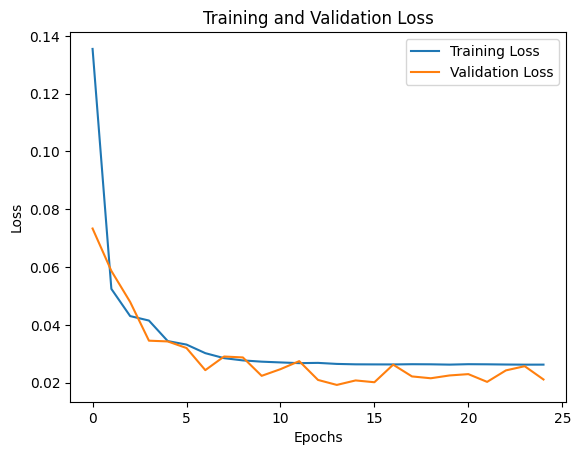

In [11]:
best_params = trial.params
best_model = build_autoencoder(optuna.trial.FixedTrial(best_params))

# Entrena el modelo final con los mejores parámetros
history = best_model.fit(x_train, x_train_b,
               epochs=25,  
               batch_size=32,
               validation_data=(x_test, x_test_b))

# Evaluación del modelo en el conjunto de prueba
test_loss = best_model.evaluate(x_test, x_test_b)
print("Test loss (MSE):", test_loss)

# Plotting training and validation losses
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


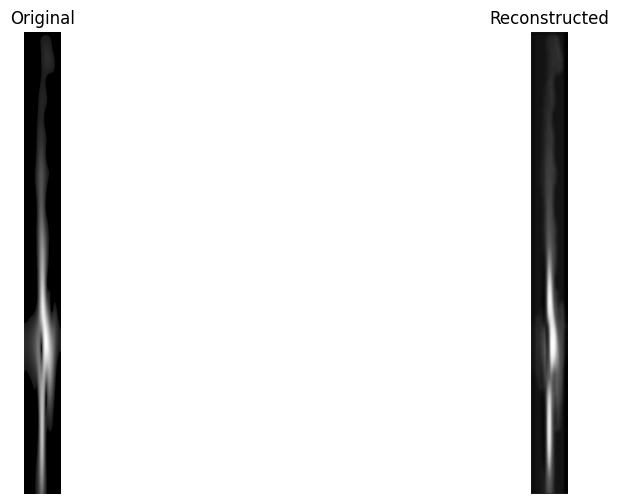

In [12]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Path to the input image
image_path = "C:/Users/TSE LATAM/Documents/Navarra/TFM/datasets/Medidas_en_2D/train/image_100.png"

# Function to load and prepare the image
def prepare_image(img_path):
    # Check if the file exists
    if not os.path.exists(img_path):
        print(f"The file {img_path} does not exist.")
        return None

    # Load image in grayscale
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Failed to load image from {img_path}.")
        return None

    # Resize image to match the model's expected input dimensions
    img = cv2.resize(img, (128, 1600))  # Ensure the dimensions are correct
    img = np.array(img).astype('float32') / 255.0  # Normalize pixel values
    img = np.expand_dims(img, axis=-1)  # Add a channel dimension
    img = np.expand_dims(img, axis=0)  # Add a batch dimension for prediction
    return img

# Prepare the image
input_image = prepare_image(image_path)


if input_image is not None:
    # Perform prediction
    decoded_image = best_model.predict(input_image)

    # Display the original and reconstructed images
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(input_image[0].reshape(1600, 128), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(decoded_image[0].reshape(1600, 128), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')

    plt.show()
else:
    print("The image could not be prepared, and no prediction was performed.")


In [13]:
best_model.summary()


Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 1600, 128, 1)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_70 (Conv2D)              │ (None, 1600, 128, 16)  │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_60 (LeakyReLU)      │ (None, 1600, 128, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_60          │ (None, 1600, 128, 16)  │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 800, 64, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 800, 64, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_71 (Conv2D)              │ (None, 800, 64, 64)    │         9,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_61 (LeakyReLU)      │ (None, 800, 64, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_61          │ (None, 800, 64, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 400, 32, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 400, 32, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_72 (Conv2D)              │ (None, 400, 32, 64)    │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_62 (LeakyReLU)      │ (None, 400, 32, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_62          │ (None, 400, 32, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 200, 16, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 200, 16, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_30 (UpSampling2D) │ (None, 400, 32, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_73 (Conv2D)              │ (None, 400, 32, 64)    │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_63 (LeakyReLU)      │ (None, 400, 32, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_63          │ (None, 400, 32, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_31 (UpSampling2D) │ (None, 800, 64, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_74 (Conv2D)              │ (None, 800, 64, 64)    │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_64 (LeakyReLU)      │ (None, 800, 64, 64)    │             

 Total params: 391,109 (1.49 MB)

 Trainable params: 130,177 (508.50 KB)

 Non-trainable params: 576 (2.25 KB)

 Optimizer params: 260,356 (1017.02 KB)

**EVALUACION DEL MODELO OPTIMIZADO**

In [14]:
import numpy as np
import keras
from keras.models import load_model

x_train_autec = x_out_1601[:, 1:1601, :, :]
x_test_autec = x_out_1601_test[:, 1:1601, :, :]

x_train_autec = x_train_autec.astype('float32') / 255.0
x_test_autec = x_test_autec.astype('float32') / 255.0


# Predecir usando el modelo cargado
predictions_train = best_model.predict(x_train_autec)
predictions_test = best_model.predict(x_test_autec)

print("Predicciones guardadas correctamente.")


150/150 ━━━━━━━━━━━━━━━━━━━━ 194s 1s/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step
Predicciones guardadas correctamente.


In [15]:
import tensorflow as tf
from functools import partial
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Convert string labels to numerical labels
label_encoder = LabelEncoder()
labels_1601_categorical = label_encoder.fit_transform(labels_1601)
labels_1601_categorical_test = label_encoder.transform(test_labels_1601)


c:\Users\TSE LATAM\.conda\envs\reto\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 16s 105ms/step - accuracy: 0.1285 - loss: 2.8509 - val_accuracy: 0.5004 - val_loss: 2.0322
Epoch 2/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 14s 90ms/step - accuracy: 0.3375 - loss: 2.0315 - val_accuracy: 0.6975 - val_loss: 1.3748
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 14s 90ms/step - accuracy: 0.5302 - loss: 1.4443 - val_accuracy: 0.7367 - val_loss: 1.0489
Epoch 4/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 14s 90ms/step - accuracy: 0.6085 - loss: 1.1446 - val_accuracy: 0.7692 - val_loss: 0.9136
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 14s 90ms/step - accuracy: 0.6794 - loss: 0.9694 - val_accuracy: 0.7579 - val_loss: 0.8689
Epoch 6/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 14s 90ms/step - accuracy: 0.7284 - loss: 0.8456 - val_accuracy: 0.7862 - val_loss: 0.8566
Epoch 7/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 14s 91ms/step - accuracy: 0.7522 - loss: 0.7413 - val_accuracy: 0.7754 - val_loss: 0.8203
Epoch 8/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 14s 90ms/step - accuracy: 0.7780 - loss: 

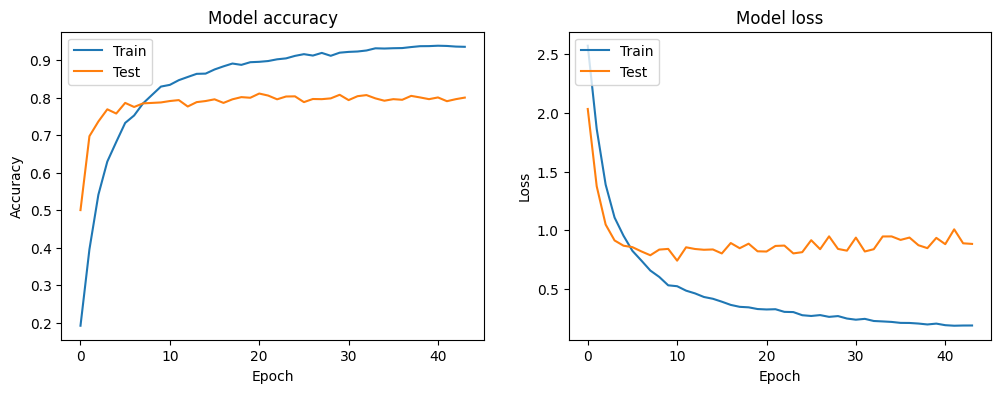

75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step


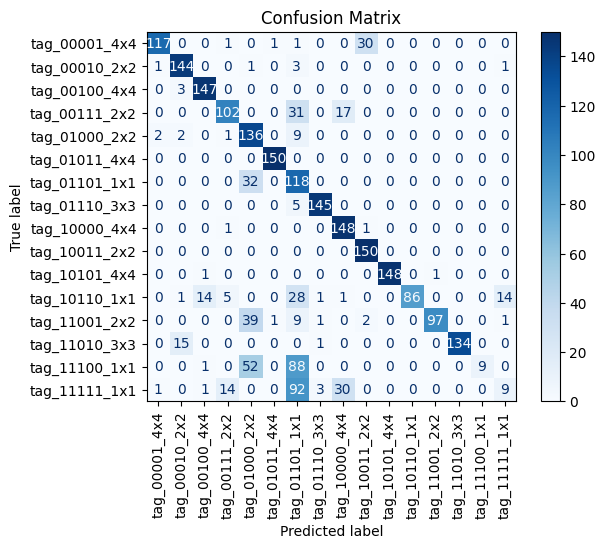

Exactitud del modelo: 76.67%
Tasa de errores: 23.33%


In [16]:
import tensorflow as tf
from functools import partial

DefaultConv2D = partial(
    tf.keras.layers.Conv2D,
    kernel_size=5,
    padding='same',
    activation='relu',
    kernel_initializer='he_normal'
)

model = tf.keras.Sequential([
    DefaultConv2D(filters=2, input_shape=(1600, 128, 1)),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    DefaultConv2D(filters=4),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=8),
    tf.keras.layers.MaxPool2D(pool_size=(3,3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(units=16, activation='softmax')
])

callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', min_delta=0.01, patience=10)

model.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3),
                metrics=['accuracy'])

# Train the model
history = model.fit(predictions_train, labels_1601_categorical, epochs=100, validation_data=(predictions_test, labels_1601_categorical_test), callbacks=[callback])


# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

# Generate predictions and plot confusion matrix
y_pred = model.predict(x_test_autec)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(labels_1601_categorical_test, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)  # Rotate x-axis labels by 90 degrees
plt.title('Confusion Matrix')
plt.show()

# Calcula y muestra la exactitud y la tasa de errores
accuracy = np.trace(cm) / np.sum(cm)
print(f"Exactitud del modelo: {accuracy * 100:.2f}%")
error_rate = 1 - accuracy
print(f"Tasa de errores: {error_rate * 100:.2f}%")

**Modelo de clasificacion optimizado con Optuna**

In [17]:
import optuna
import tensorflow as tf
from functools import partial
from sklearn.model_selection import train_test_split

# Datos listos
X_train = predictions_train
X_test = predictions_test
y_train = labels_1601_categorical
y_test = labels_1601_categorical_test

def create_model(trial):
    # Definir los hiperparámetros a optimizar
    conv_filters_1 = trial.suggest_categorical('conv_filters_1', [2, 8, 16])
    conv_filters_2 = trial.suggest_categorical('conv_filters_2', [4, 16, 32])
    conv_filters_3 = trial.suggest_categorical('conv_filters_3', [8, 32, 64])
    dense_units = trial.suggest_categorical('dense_units', [16])
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.7)

    DefaultConv2D = partial(
        tf.keras.layers.Conv2D,
        kernel_size=5,
        padding='same',
        activation='relu',
        kernel_initializer='he_normal'
    )

    model = tf.keras.Sequential([
        DefaultConv2D(filters=conv_filters_1, input_shape=(1600, 128, 1)),
        tf.keras.layers.MaxPool2D(pool_size=(2,2)),
        DefaultConv2D(filters=conv_filters_2),
        tf.keras.layers.MaxPool2D(),
        DefaultConv2D(filters=conv_filters_3),
        tf.keras.layers.MaxPool2D(pool_size=(3,3)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(rate=dropout_rate),
        tf.keras.layers.Dense(units=dense_units, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

def objective(trial):
    model = create_model(trial)
    
    # Entrenamiento del modelo
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=10,  
        batch_size=32,
        verbose=0
    )
    
    # Evaluar el modelo
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    return accuracy

# Crear estudio y optimizar
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)  # Puedes ajustar el número de pruebas

# Obtener los mejores parámetros
best_params = study.best_params
print("Mejores parámetros:", best_params)

# Opcional: Entrenar el modelo final con los mejores parámetros
model = create_model(study.best_trial)
model.fit(X_train, y_train, epochs=10, batch_size=32)


[I 2024-08-25 07:03:17,147] A new study created in memory with name: no-name-adadcb79-9f03-4ea3-b964-297b5d1520c4
c:\Users\TSE LATAM\.conda\envs\reto\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
[I 2024-08-25 07:15:00,371] Trial 0 finished with value: 0.8233333230018616 and parameters: {'conv_filters_1': 16, 'conv_filters_2': 16, 'conv_filters_3': 32, 'dense_units': 16, 'dropout_rate': 0.2781556245718369}. Best is trial 0 with value: 0.8233333230018616.
[I 2024-08-25 07:18:19,550] Trial 1 finished with value: 0.8416666388511658 and parameters: {'conv_filters_1': 2, 'conv_filters_2': 4, 'conv_filters_3': 32, 'dense_units': 16, 'dropout_rate': 0.40608760164176727}. Best is trial 1 with value: 0.8416666388511658.
[I 2024-08-25 07:34:01,783] Trial 2 finished with value

Mejores parámetros: {'conv_filters_1': 8, 'conv_filters_2': 16, 'conv_filters_3': 64, 'dense_units': 16, 'dropout_rate': 0.6460572995149882}
Epoch 1/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 51s 333ms/step - accuracy: 0.4824 - loss: 1.9227
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 50s 334ms/step - accuracy: 0.9130 - loss: 0.2736
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 51s 339ms/step - accuracy: 0.9518 - loss: 0.1552
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 52s 348ms/step - accuracy: 0.9592 - loss: 0.1166
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 50s 335ms/step - accuracy: 0.9752 - loss: 0.0745
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 50s 332ms/step - accuracy: 0.9815 - loss: 0.0577
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 51s 340ms/step - accuracy: 0.9806 - loss: 0.0590
Epoch 8/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 50s 332ms/step - accuracy: 0.9858 - loss: 0.0417
Epoch 9/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 50s 334ms/step - accuracy: 0.9877 - loss: 0.0365
Epoch 10/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 51s 342ms/step - 

In [18]:
# Opcional: Entrenar el modelo final con los mejores parámetros
model = create_model(study.best_trial)
model.fit(predictions_train, labels_1601_categorical, epochs=100, validation_data=(predictions_test, labels_1601_categorical_test), callbacks=[callback])


Epoch 1/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 64s 417ms/step - accuracy: 0.4441 - loss: 2.2009 - val_accuracy: 0.7554 - val_loss: 0.9320
Epoch 2/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 60s 400ms/step - accuracy: 0.8808 - loss: 0.3757 - val_accuracy: 0.7975 - val_loss: 1.0706
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 62s 413ms/step - accuracy: 0.9302 - loss: 0.2127 - val_accuracy: 0.7992 - val_loss: 1.1941
Epoch 4/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 65s 435ms/step - accuracy: 0.9552 - loss: 0.1492 - val_accuracy: 0.8225 - val_loss: 1.1040
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 64s 425ms/step - accuracy: 0.9581 - loss: 0.1220 - val_accuracy: 0.8029 - val_loss: 1.4000
Epoch 6/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 66s 441ms/step - accuracy: 0.9635 - loss: 0.1009 - val_accuracy: 0.7642 - val_loss: 1.4762
Epoch 7/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 66s 443ms/step - accuracy: 0.9711 - loss: 0.0879 - val_accuracy: 0.7929 - val_loss: 1.3054
Epoch 8/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 68s 452ms/step - accuracy: 0.9724 -